## Overview
- References: [[Mnih et. al, 2008]](https://www.cs.toronto.edu/~vmnih/docs/ebstop.pdf), [[Bardenet et. al, 2014]](https://proceedings.mlr.press/v32/bardenet14.html), and [[Wilson, 2024]](http://arxiv.org/abs/2402.16811).
- This notebook surveys the `adaptive_empirical_bernstein_estimator` method provided by `trieste_sampling`.
- Given a random variable $X: \Omega \to [a, b]$, this function generates an estimate $\overline{X}_n$ that is on the same side of  $\lambda \in [a, b]$ as $\mathbb{E}[X]$ with probabilitie at least $1 - \delta$, i.e.
  \begin{align} 
  \mathbb{P}\left[\mathbb{1}_{\overline{X}_n \le \lambda} = \mathbb{1}_{\mathbb{E}[X] \le \lambda}\right] \ge 1 - \delta.
  \end{align}
- In the code, $\lambda$ is referred to as the `threshold` and $\delta$ is referred to as the `risk_tolerance`.
- Below, we show how this method behaves when used to infer whether expected values of Bernoulli random variables exceed $\lambda = 10^{-5}$.

In [1]:
import numpy as np
import tensorflow as tf
from trieste_stopping.utils import adaptive_empirical_bernstein_estimator

num_runs = 5
num_risks = 5
num_probs = 5
threshold = 1e-5
sample_width = 1.0  # difference between maximum and minimum sample values

log_risks = np.linspace(-4, 0, num_risks)
log_probs = np.linspace(-4, 0, num_probs)
popsizes = np.zeros([num_risks, num_probs, num_runs], dtype=np.float64)

for r in range(num_runs):
    for i, risk in enumerate(np.power(10, log_risks)):
        for j, prob in enumerate(np.power(10, log_probs)):

            def sampler(n, p=prob):
                return tf.cast(tf.random.uniform([n], dtype=p.dtype) < p, p.dtype)
    
            moments, _ = adaptive_empirical_bernstein_estimator(
                sampler=sampler, 
                sample_width=sample_width,  
                threshold=threshold,
                risk_tolerance=risk,
                axis=-1,
                popsize_initial=10,
            )
            popsizes[i, j, r] = moments.popsize

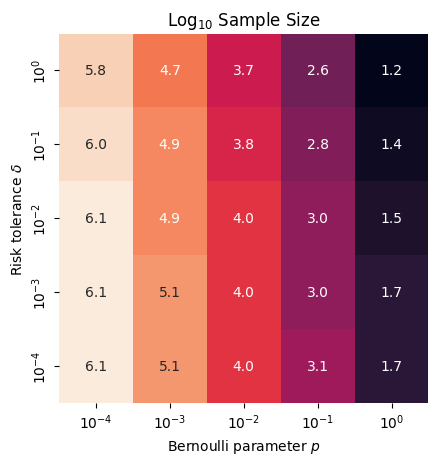

In [2]:
import seaborn as sns

ax = sns.heatmap(
    np.flipud(np.log10(np.median(popsizes, axis=-1))),
    cbar=False,
    cmap="rocket",
    fmt=".1f", 
    annot=True,
)
ax.set_title("Log$_{10}$ Sample Size")
ax.set_xlabel("Bernoulli parameter $p$")
ax.set_xticklabels([f"$10^{{{int(lp)}}}$" for lp in log_probs])
ax.set_ylabel("Risk tolerance $\delta$")
ax.set_yticklabels([f"$10^{{{int(lr)}}}$" for lr in np.flipud(log_risks)])
ax.set_aspect("equal")